# EDA

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

In [30]:
tracks_with_genres = pd.read_csv('../data/ml_analysis/tracks_with_genres.csv')

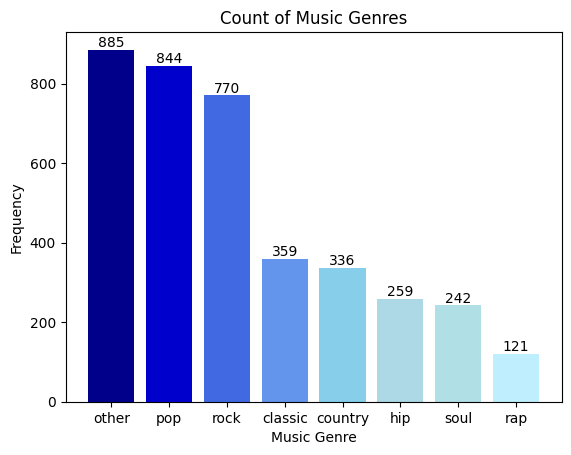

In [44]:
labels = tracks_with_genres['genre'].value_counts()
colors = ['#00008B', '#0000CD', '#4169E1', '#6495ED', '#87CEEB', '#ADD8E6', '#B0E0E6', '#BFEFFF']
plt.bar(labels.index, height=labels, color=colors)
plt.xlabel('Music Genre')
plt.ylabel('Frequency')
plt.title('Count of Music Genres')
for i, freq in enumerate(labels):
    plt.text(i, freq, str(freq), ha='center', va='bottom')
plt.savefig('report/count_of_music_genres.png', dpi=300)

# Machine Learning

In [1]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

In [2]:
train_data = np.load('train_data.npy')
train_label = np.load('train_label.npy')
test_data = np.load('test_data.npy')
test_label = np.load('test_label.npy')

# Decision Tree

In [3]:
from sklearn.tree import DecisionTreeClassifier

In [15]:
dt_default = DecisionTreeClassifier(random_state=200)
dt_default.fit(train_data, train_label)
train_pred = dt_default.predict(train_data)
accuracy_score(train_label, train_pred)

0.970520799213888

In [16]:
test_pred = dt_default.predict(test_data)
accuracy_score(test_label, test_pred)

0.3564875491480996

In [7]:
parameters = {'max_depth': np.linspace(10, 50, 5).astype(int),
              'min_samples_split': np.linspace(2, 14, 4).astype(int),
              'ccp_alpha': 10 ** np.linspace(-3, -2, 10)}
dt = GridSearchCV(DecisionTreeClassifier(random_state=350), parameters)
dt.fit(train_data, train_label)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=350),
             param_grid={'ccp_alpha': array([0.001     , 0.00129155, 0.0016681 , 0.00215443, 0.00278256,
       0.00359381, 0.00464159, 0.00599484, 0.00774264, 0.01      ]),
                         'max_depth': array([10, 20, 30, 40, 50]),
                         'min_samples_split': array([ 2,  6, 10, 14])})

In [17]:
train_pred = dt.predict(train_data)
accuracy_score(train_label, train_pred)

0.4867343596462496

In [18]:
test_pred = dt.predict(test_data)
accuracy_score(test_label, test_pred)

0.44036697247706424

# Random Forest

In [12]:
from sklearn.ensemble import RandomForestClassifier

In [19]:
rf_default = RandomForestClassifier(random_state=1000)
rf_default.fit(train_data, train_label)
train_pred = rf_default.predict(train_data)
accuracy_score(train_label, train_pred)

0.970520799213888

In [20]:
test_pred = rf_default.predict(test_data)
accuracy_score(test_label, test_pred)

0.5045871559633027

In [22]:
parameters = {'max_depth': np.linspace(10, 50, 5).astype(int),
              'min_samples_split': np.linspace(2, 14, 4).astype(int),
              'ccp_alpha': 10 ** np.linspace(-3, -2, 10)}
rf = GridSearchCV(RandomForestClassifier(random_state=355), parameters)
rf.fit(train_data, train_label)

GridSearchCV(estimator=RandomForestClassifier(random_state=355),
             param_grid={'ccp_alpha': array([0.001     , 0.00129155, 0.0016681 , 0.00215443, 0.00278256,
       0.00359381, 0.00464159, 0.00599484, 0.00774264, 0.01      ]),
                         'max_depth': array([10, 20, 30, 40, 50]),
                         'min_samples_split': array([ 2,  6, 10, 14])})

In [23]:
train_pred = rf.predict(train_data)
accuracy_score(train_label, train_pred)

0.804454634785457

In [24]:
pred = rf.predict(test_data)
accuracy_score(test_label, pred)

0.47313237221494103

# Gradient Boosting

In [26]:
from sklearn.ensemble import GradientBoostingClassifier

In [27]:
gbm_default = GradientBoostingClassifier(random_state=999)
gbm_default.fit(train_data, train_label)
train_pred = gbm_default.predict(train_data)
accuracy_score(train_label, train_pred)

0.7392728463806092

In [28]:
test_pred = gbm_default.predict(test_data)
accuracy_score(test_label, test_pred)

0.4875491480996068

# XGBoost

In [17]:
import xgboost as xgb

In [18]:
dtrain = xgb.DMatrix(data=train_data, label=train_label)
dtest = xgb.DMatrix(data=test_data)

In [23]:
parameters = {'objective': 'multi:softmax', 'num_class': 13, 'seed': 100}
bst_default = xgb.train(parameters, dtrain)
pred = bst_default.predict(dtest)
accuracy_score(test_label, pred)

0.4783748361730013

In [25]:
parameters = {'objective': 'multi:softmax',
              'num_class': 8,
              'seed': 300,
              'eta': 0.001}
bst = xgb.cv(params=parameters,
             dtrain=dtrain,
             num_boost_round=100,
             nfold=5,
             seed=300)

,train-mlogloss-mean,train-mlogloss-std,test-mlogloss-mean,test-mlogloss-std
0,2.078183,0.000010,2.078619,0.000026
1,2.076927,0.000020,2.077800,0.000055
2,2.075674,0.000030,2.076983,0.000080
3,2.074422,0.000039,2.076168,0.000108
4,2.073174,0.000049,2.075357,0.000136
...,...,...,...,...
95,1.968749,0.000812,2.007165,0.002582
96,1.967689,0.000824,2.006467,0.002595
97,1.966630,0.000833,2.005772,0.002602
98,1.965574,0.000840,2.005082,0.002616
